# <center><span style="font-family:cursive;"> 😸🐶A SIMPLE CAT/DOG CLASSIFIER </span></center>



<center><img src="https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg"></center>





In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

<h1 id="basics" style="font-family:cursive;"> 
    <center>1. Building Training,validation and test Dataset
        <a class="anchor-link" href="https://www.kaggle.com/afiaibnath/pytorch-cat-or-dog-classifier-from-scratch/edit">¶</a>
    </center>
</h1>

In [4]:
train_data_path = "/kaggle/input/cat-and-dog/training_set/training_set"
test_data_path="/kaggle/input/cat-and-dog/test_set/test_set"

In [5]:
#this is preprocessing step of images
img_transforms = transforms.Compose([
#Because we have bunch of images of non similar aspect ratio
#Scaling is necessary to improve processing performance
transforms.Resize(size=224),
transforms.CenterCrop(size=224),
transforms.ToTensor(),
#normalization is necessary to prevent exploding gradient problem    
transforms.Normalize(mean=[0.4895, 0.4517, 0.4130],
std=[0.2587, 0.2506, 0.2514])
#to get the normalizing tensor values comment above two lines and run the get_mean_std(loader) function
])

In [6]:
DATASET = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)
print(len(DATASET))
DATASET[0][0].shape

8005


torch.Size([3, 224, 224])

In [7]:
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(DATASET):
        channels_sum += torch.mean(data, dim=[1, 2])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[1,2])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


mean, std = get_mean_std(DATASET)
print(mean)
print(std)


100%|██████████| 8005/8005 [00:51<00:00, 155.13it/s]

tensor([0.0056, 0.0150, 0.0165])
tensor([1.0017, 1.0048, 1.0092])


In [8]:
#dividing train data into train and validation data
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split,random_state=42)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets = train_val_dataset(DATASET)
print(len(datasets['train']))
print(len(datasets['val']))

6404
1601


In [9]:
#test data must have same preprocessing step as train data
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms)
#loading data to feed into neural network
batch_size=32
train_data_loader = DataLoader(datasets['train'], batch_size=batch_size)
val_data_loader = DataLoader(datasets['val'], batch_size=batch_size)
test_data_loader = DataLoader(test_data, batch_size=batch_size)

In [10]:
#Let's have a look on the tensor size for each batches 
for image_batch, label_batch in train_data_loader:
    print(image_batch.size(),label_batch.size())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


<h1 id="visual" style="font-family:cursive;"> 
    <center>2. Visualizing data 👀
        <a class="anchor-link" href="https://www.kaggle.com/afiaibnath/pytorch-cat-or-dog-classifier-from-scratch/edit">¶</a>
    </center>
</h1>

>Ref: https://www.kaggle.com/marcosvafg/pytorch-cat-and-dog-resnet50

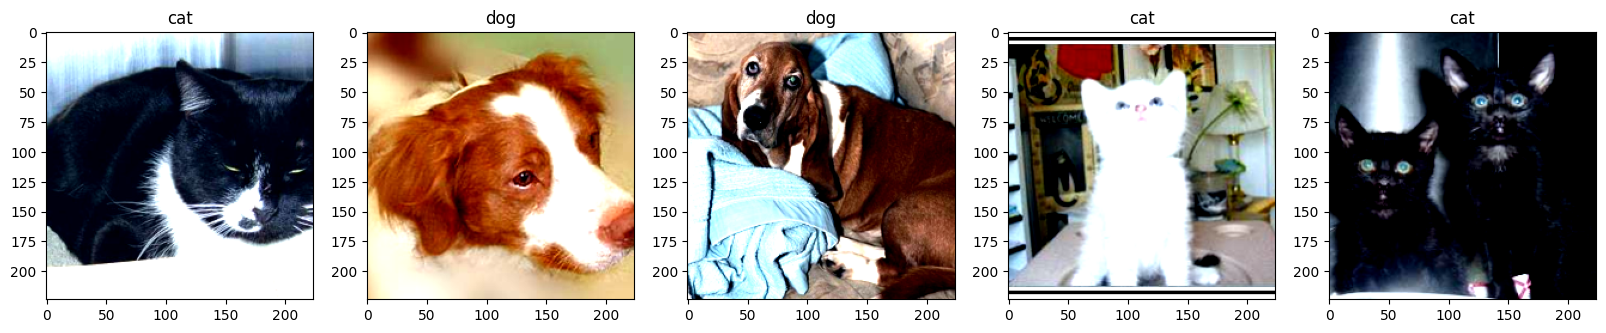

In [11]:
#to normalize images
def image_convert(img):
    img = img.clone().cpu().numpy()
    img = img.transpose(1,2,0)
    std = [0.5,0.5,0.5]
    mean = [0.5,0.5,0.5]
    img = img*std + mean
    return img

def plot_10():
        iter_ = iter(train_data_loader)
        images,labels = next(iter_)
        an_ = {'0':'cat','1':'dog'}# changing labels to be meaningful
        
        plt.figure(figsize=(20,10))
        for idx in range(5):
            plt.subplot(2,5,idx+1)
            img = image_convert(images[idx])
            label = labels[idx]
            plt.imshow(img)
            plt.title(an_[str(label.numpy())])
        plt.show()
        
plot_10()

<h1 id="model" style="font-family:cursive;"> 
    <center>3. Building model to train data
        <a class="anchor-link" href="https://www.kaggle.com/afiaibnath/pytorch-cat-or-dog-classifier-from-scratch/edit">¶</a>
    </center>
</h1>


In [12]:
import torch
import torch.nn as nn
from torchvision import models

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(SimpleCNN, self).__init__()
        self.model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        return self.model(x)


In [13]:
#optimizer helps in finding the suitable weight values to yield minimum loss between prediction and ground values
#small learning rate(lr) is preferable
model = SimpleCNN()  # Instantiate your model
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


<h1 id="train" style="font-family:cursive;"> 
    <center>4. Finally!!Let's train our model 😄
        <a class="anchor-link" href="https://www.kaggle.com/afiaibnath/pytorch-cat-or-dog-classifier-from-scratch/edit">¶</a>
    </center>
</h1>


In [14]:
#transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=2)
model = model.to(device)



In [15]:
for param in model.model.parameters():
    param.requires_grad = True

In [18]:
import torch
import torch.nn.functional as F

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0
        num_examples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                output = model(inputs)
                loss = loss_fn(output, targets)
                valid_loss += loss.data.item() * inputs.size(0)
                correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print(
            'Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
                epoch, training_loss, valid_loss, num_correct / num_examples
            )
        )

        # Save the model after each epoch
        
        save_path = f"model_epoch_{epoch}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Model saved at: {save_path}")

In [19]:
model = SimpleCNN()  
model = model.to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4) 
train(model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=20, device=device)


Epoch: 1, Training Loss: 0.22, Validation Loss: 0.19, accuracy = 0.92
Model saved at: model_epoch_1.pth


epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
train_loss: [0.21, 0.14, 0.09, 0.09, 0.08, 0.05, 0.06, 0.06, 0.06, 0.09, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.02, 0.04, 0.03, 0.02]
val_loss: [0.23, 0.17, 0.22, 0.21, 0.19, 0.19, 0.16, 1.14, 0.36, 0.16, 0.27, 0.17, 0.17, 0.2, 0.22, 0.24, 0.31, 0.22, 0.2, 0.23]
accuracy: [0.9, 0.92, 0.91, 0.92, 0.94, 0.94, 0.95, 0.73, 0.89, 0.94, 0.9, 0.94, 0.94, 0.94, 0.94, 0.94, 0.91, 0.95, 0.93, 0.94]


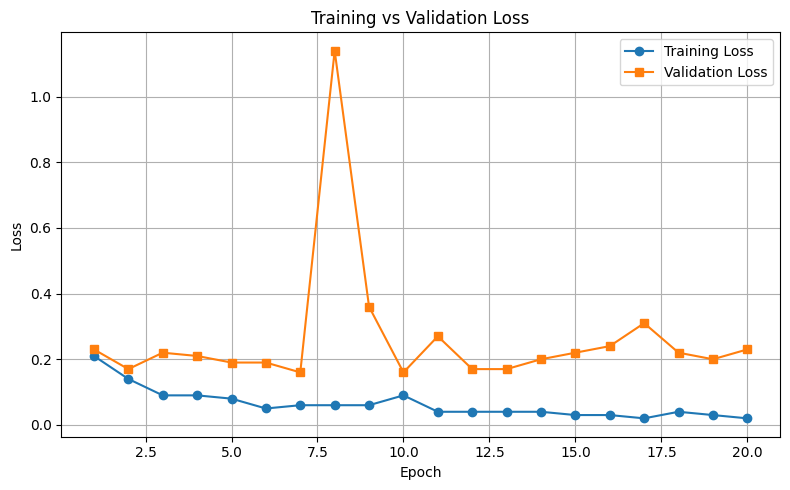

In [29]:
import re
import matplotlib.pyplot as plt

log_file = '/kaggle/input/log-file/download (8).txt'  # Update path if needed

with open(log_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()

pattern = re.compile(r"Epoch: (\d+), Training Loss: ([\d.]+), Validation Loss: ([\d.]+), accuracy = ([\d.]+)")

epochs, train_loss, val_loss, accuracy = [], [], [], []

for line in lines:
    match = pattern.search(line)
    if match:
        epochs.append(int(match.group(1)))
        train_loss.append(float(match.group(2)))
        val_loss.append(float(match.group(3)))
        accuracy.append(float(match.group(4)))

print('epochs:', epochs)
print('train_loss:', train_loss)
print('val_loss:', val_loss)
print('accuracy:', accuracy)

if epochs and train_loss and val_loss:
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, marker='o', label='Training Loss')
    plt.plot(epochs, val_loss, marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print('No data extracted from log file!')


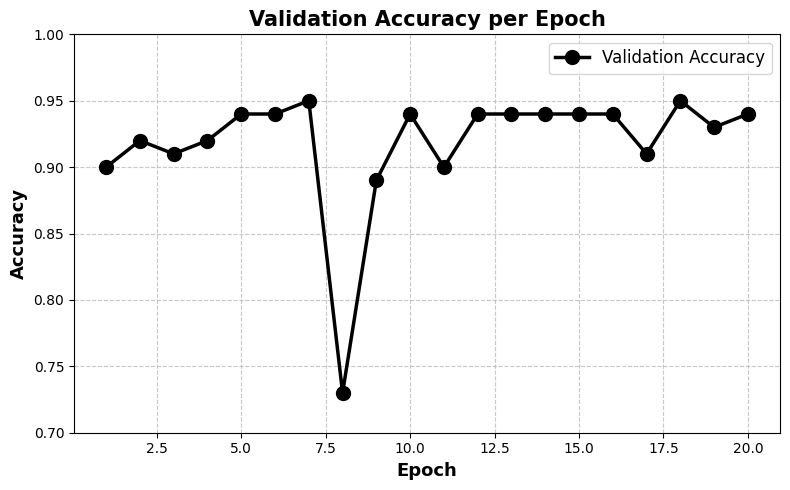

In [30]:
import matplotlib.pyplot as plt

# Provided accuracy values
accuracy = [0.9, 0.92, 0.91, 0.92, 0.94, 0.94, 0.95, 0.73, 0.89, 0.94, 0.9, 0.94, 0.94, 0.94, 0.94, 0.94, 0.91, 0.95, 0.93, 0.94]
epochs = list(range(1, len(accuracy) + 1))

plt.figure(figsize=(8, 5))
plt.plot(
    epochs,
    accuracy,
    marker='o',
    color='black',         # Use black for maximum visibility
    linewidth=2.5,
    markersize=10,
    label='Validation Accuracy'
)
plt.xlabel('Epoch', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.title('Validation Accuracy per Epoch', fontsize=15, fontweight='bold')
plt.ylim(0.7, 1.0)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h1 id="pred" style="font-family:cursive;"> 
    <center>5. Making prediction
        <a class="anchor-link" href="https://www.kaggle.com/afiaibnath/pytorch-cat-or-dog-classifier-from-scratch/edit">¶</a>
    </center>
</h1>

In [25]:
labels = ['cat', 'dog']

img = Image.open("/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4009.jpg")
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)

model = SimpleCNN()
model.load_state_dict(torch.load('/kaggle/input/model-weight/model_epoch_20.pth'))  # If you have saved weights
model = model.to(device)
model.eval()

with torch.no_grad():
    output = model(img)
    prediction = F.softmax(output, dim=1)
    predicted_class = prediction.argmax()
    print(labels[predicted_class])


dog


TypeError: only integer tensors of a single element can be converted to an index

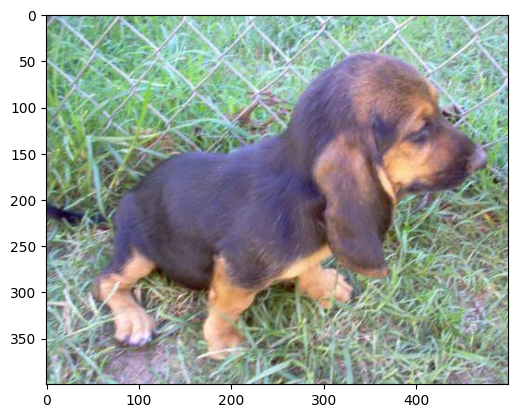

In [24]:
img = Image.open("/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4009.jpg") 
plt.imshow(img)
plt.title(str(labels[prediction]))
plt.show()